# Parameter Estimation Methods on Cartpole Control Tasks

## Import packages

In [76]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
from collections import deque
np.set_printoptions(precision=4, suppress=True)
# Note: autograd does not work with np.block

## Cart Pole Dynamics 

In [81]:

from matplotlib.animation import FuncAnimation
class Cart_Pole():
    def __init__(self):
        self.mc, self.mp = 1.0, 1  # masses
        self.l = 0.5  # lengths
        self.g = 9.81  # gravity
        self.A_jac = jacobian(self.double_pen_rk4, 0) 
        self.B_jac = jacobian(self.double_pen_rk4, 1)
        
        self.max_dev_x = np.array([np.pi / 2, 1.0, np.pi / 2, 1.0])  # max deviations for states
        self.max_dev_u = np.array([50.0, 0.0001])  # max control effort

    def double_pendulum_dynamics(self, state, u, mc, mp, l, g):
        pos, vel, angular_pos, angular_vel = state
        fx=u
        # # Mass matrix M(q)
        # M = np.array([
        #     [mc + mp, mp * l * np.cos(angular_pos)],
        #     [mp * l * np.cos(angular_pos), mp * l**2]
        # ])

        # # Coriolis and centrifugal forces C(q, q̇)
        # C = np.array([
        #     [0, -mp * l * angular_vel * np.sin(angular_pos)],
        #     [0, 0]
        # ])

        # # Gravity effects τ_g(q)
        # tau_g = np.array([
        #     [0],
        #     [-mp * g * l * np.sin(angular_pos)]
        # ])

        # # Control input matrix B
        # Bu = np.array([[fx], [0]])
        # # Compute accelerations
        # q_dot = np.array([[vel], [angular_vel]])
        # q_ddot = np.linalg.inv(M) @ (Bu - C @ q_dot - tau_g)
        # print("vel", vel, "acc", q_ddot[0, 0], "ang_vel", angular_vel, "ang_acc", q_ddot[1, 0])
        # # Return the derivatives [x_dot, x_ddot, theta_dot, theta_ddot]
        # return np.array([vel, q_ddot[0, 0], angular_vel, q_ddot[1, 0]])

        #another implementation
        M = mc+mp 
        top = (mp*g*np.sin(angular_pos)*np.cos(angular_pos) - (1+1/3)*(fx+mp*l*angular_vel**2*np.sin(angular_pos)))
        bottom = mp*np.cos(angular_pos)**2-(1+1/3)*M
        x_acc = top/bottom
        angular_acc = g*np.sin(angular_pos)-x_acc*np.cos(angular_pos)
        print(vel, x_acc[0], angular_vel, angular_acc[0])
        return np.array([vel, x_acc[0], angular_vel, angular_acc[0]])
    # Runge-Kutta 4th order integration
    def double_pen_rk4(self, x, u, mc, mp, l, g):
        h = 0.01
       # x=np.ravel(x)
       # print("doublepenrk4: ",x[0])
        k1 = self.double_pendulum_dynamics(x, u, mc, mp, l, g)
        k2 = self.double_pendulum_dynamics(x + 0.5 * h * k1, u, mc, mp, l, g)
        k3 = self.double_pendulum_dynamics(x + 0.5 * h * k2, u, mc, mp, l, g)
        k4 = self.double_pendulum_dynamics(x + h * k3, u, mc, mp, l, g)
        
        return x + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    # def get_swingup_goals(self, state, m1, m2, l1, l2, g):
    #     self.x = np.array([np.pi / 4, 0, 0, 0])
    #     return self.x

    def get_linearized_dynamics(self, xg, u,  mc, mp, l, g):
      
        Anp = self.A_jac(xg, u,  mc, mp, l, g) 
        Bnp = self.B_jac(xg, u,  mc, mp, l, g).reshape(4,1) 
        #print(Anp,"b",Bnp)
    #    Bnp = Bnp / np.max(np.abs(Bnp))  # Normalize B to prevent LQR from overreacting 
        self.Anp = Anp
        self.Bnp = Bnp
        return self.Anp, self.Bnp

0.0 0.3411234571963268 0.0 -0.24300803615742628
0.001705617285981634 0.34112346310116465 -0.0012150401807871315 -0.2430080420619689
0.0017056173155058233 0.34115923729869274 -0.0012150402103098445 -0.24310342993308656
0.0034115923729869276 0.3411950292082661 -0.0024310342993308655 -0.24319883551363458
0.003411473145340513 0.34119503856313177 -0.0024307163594352865 -0.24319886046762465
0.005117448338156172 0.34126663514248384 -0.0036467106617734096 -0.24338971557355954
0.005117806321052932 0.341302437426136 -0.0036476649373030842 -0.2434851783244225
0.0068244975196018725 0.34140990418919176 -0.004865568142679511 -0.2437716576782211
0.0068243782918231185 0.34140989481483075 -0.004865250202671636 -0.24377163270304494
0.008531427765897272 0.3415531941792958 -0.006084108366186861 -0.24415363628788805
0.008532144262719598 0.34158908077933814 -0.006086018384111077 -0.24424932382753844
0.0102402690996165 0.3417683907034431 -0.0073077434409470204 -0.2447273262158475
0.010240149684215688 0.34176

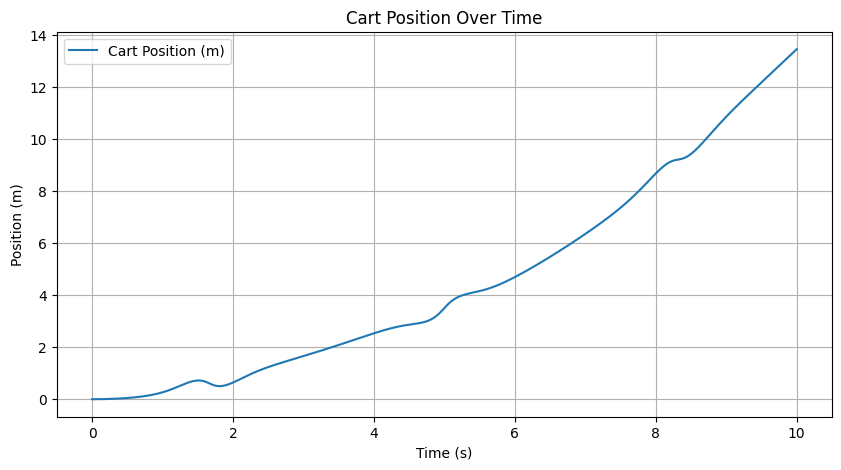

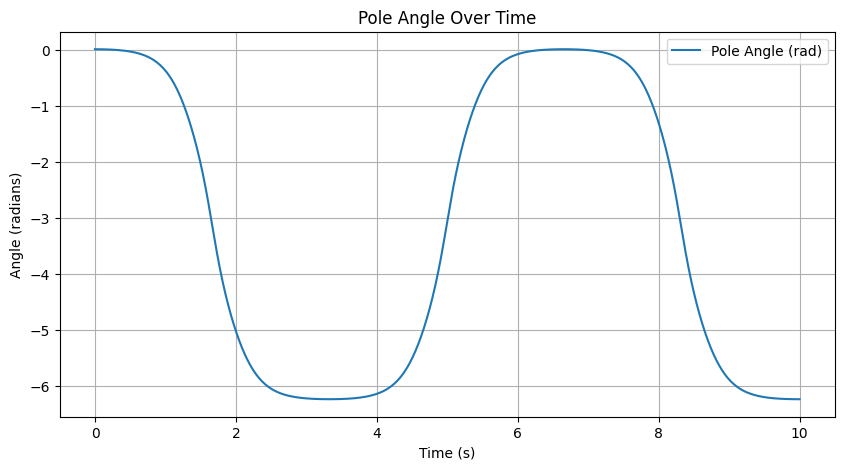

In [78]:
import matplotlib.pyplot as plt

# Initialize Cart-Pole system
cartpole = Cart_Pole()

# Define initial state: [cart position, cart velocity, pole angle, pole angular velocity]
initial_state = np.array([0.0, 0, 0.01, 0])  # Small angle deviation

# Simulation parameters
dt = 0.01  # Time step
NSIM = int(10 / dt)  # Number of simulation steps
force = 0.5  # Constant force applied to the cart

# Store results
state_history = [initial_state]
time_history = [0]

# Run the simulation
x_curr = initial_state
lst = list(range(0, NSIM))  
for i in range(NSIM):
    if i in lst:
        x_curr = cartpole.double_pen_rk4(x_curr, force, cartpole.mc, cartpole.mp, cartpole.l, cartpole.g)
    else:
        x_curr = cartpole.double_pen_rk4(x_curr, 0, cartpole.mc, cartpole.mp, cartpole.l, cartpole.g)

    state_history.append(x_curr)
    time_history.append(time_history[-1] + dt)

# Convert results to NumPy arrays
state_history = np.array(state_history)

# Extract position and angle
cart_positions = state_history[:, 0]  # x (cart position)
pole_angles = state_history[:, 2]  # θ (pole angle)

# **Plot Cart Position Over Time**
plt.figure(figsize=(10, 5))
plt.plot(time_history, cart_positions, label="Cart Position (m)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Cart Position Over Time")
plt.legend()
plt.grid()
plt.show()

# **Plot Pole Angle Over Time**
plt.figure(figsize=(10, 5))
plt.plot(time_history, pole_angles, label="Pole Angle (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (radians)")
plt.title("Pole Angle Over Time")
plt.legend()
plt.grid()
plt.show()


In [79]:
from scipy.linalg import solve_continuous_are

class LQRController():
    def __init__(self):
        pass

    def update_linearized_dynamics (self, Anp, Bnp, Q, R):
        self.Anp = Anp
        self.Bnp = Bnp
        self.Q = Q
        self.R = R

    def dlqr(self, A, B, Q, R, n_steps=100):
        """
        Solves the continuous-time algebraic Riccati equation to compute the optimal gain matrix K.
        """
        P = Q
        for i in range(n_steps):
            K = inv(R + B.T @ P @ B) @ B.T @ P @ A
            P = Q + A.T @ P @ (A - B @ K)
        # A_norm = A / (np.max(np.abs(A)) + 1e-6)
        # B_norm = B / (np.max(np.abs(B)) + 1e-6)
        # Q_norm = Q / (np.max(np.abs(Q)) + 1e-6)
        # R_norm = R / (np.max(np.abs(R)) + 1e-6)

        # P = solve_continuous_are(A_norm, B_norm, Q_norm, R_norm)
        # K = np.linalg.inv(R_norm) @ B_norm.T @ P

        return K, P
    def get_QR_bryson(self):
        max_dev_x = np.array([10, 5, 2*np.pi, 2])  # max deviations for states
        max_dev_u = np.array([15.0])  # max control effort
        Q = np.diag(1./max_dev_x**2)
        R = np.diag(1./max_dev_u**2)
        print("Q: ", Q, "R: ", R)
        return Q, R
    def compute(self, x_curr, x_desired):
        """
        Compute control input using the LQR gain matrix.
        Returns:
            control_input: Control input to stabilize the system.
        """
        K_lqr, P_lqr = self.dlqr(self.Anp, self.Bnp, self.Q, self.R)
        delta_x = x_curr - x_desired
        print("deltax: ", delta_x)
        print("K_lqr: ", K_lqr)
        print("control", K_lqr @ delta_x )
        return K_lqr @ delta_x




Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with value 0.0
Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with value 0.0
Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with value 0.0
Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with value 0.0
0.0 Autograd ArrayBox with value -0.0 0.0 Autograd ArrayBox with value 0.0
Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with value 0.0
Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with value 0.0
Autograd ArrayBox with value 0.0 Autograd ArrayBox with value -0.0 Autograd ArrayBox with value 0.0 Autograd ArrayBox with valu

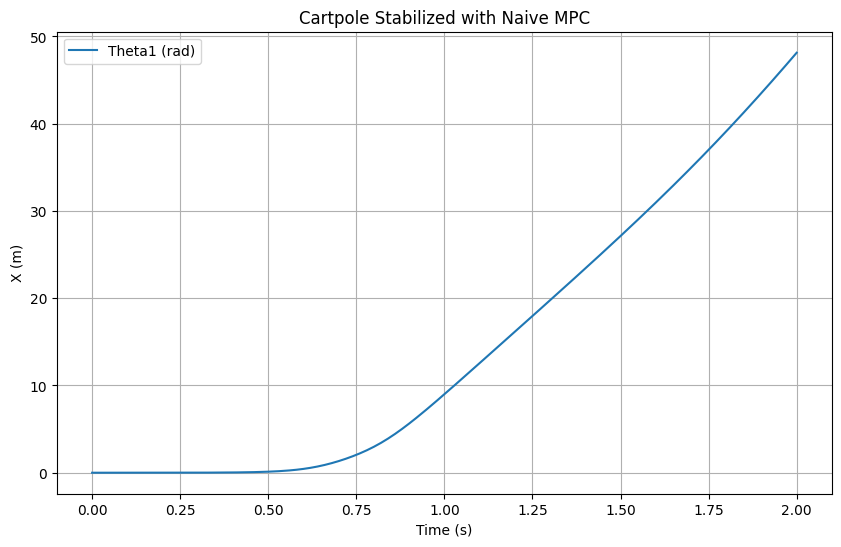

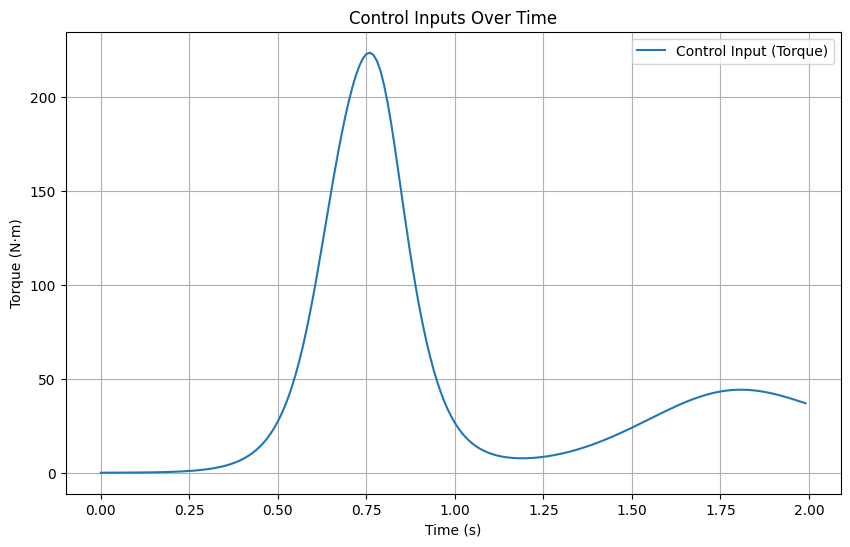

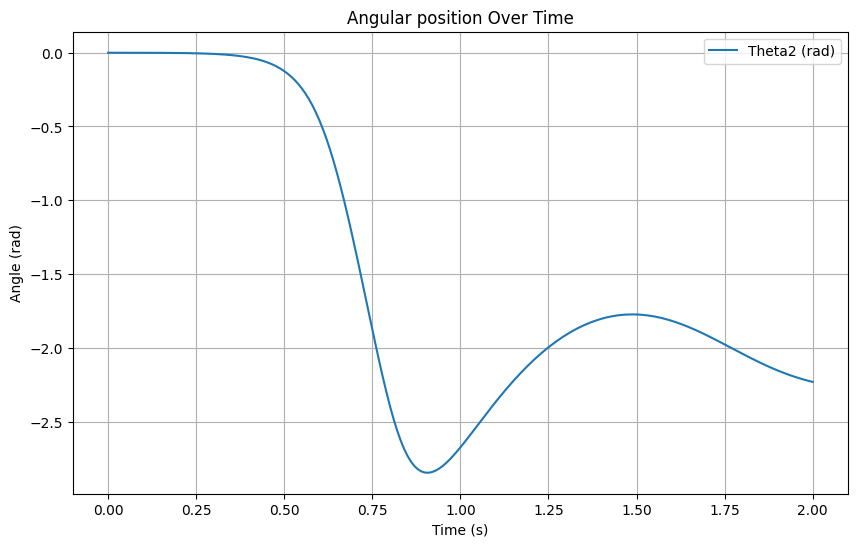

In [90]:

def simulate_with_controller_naive_MPC(cartpole, cartpole_controller, x0, x_nom, update_status="immediate_update", NSIM=200):
    x_all = []
    u_all = []
    theta_all = []
    x_curr = np.copy(x0)
    x_prev = np.copy(x0)
    u_curr = np.array([0.1])
    x_all.append(x_curr)
    u_all.append(u_curr)
    ang = x_curr[2]  # Pole angle
    ang_vel = x_curr[3]

    mc, mp, l, g = cartpole.mc, cartpole.mp, cartpole.l, cartpole.g
    u_nom = np.array([mp * g * l * np.sin(ang) + mp * l * ang_vel**2 * np.cos(ang)])

    Anp, Bnp = cartpole.get_linearized_dynamics(x_nom, u_nom , mc, mp, l, g)
    Q, R = cartpole_controller.get_QR_bryson()
    # print("Q here is ", Q, "R here is ", R)
    cartpole_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
    
    for i in range(NSIM):
        # Change gravity at step 50
        print(i)
        if i == 50:
            change_params = True
            g = 1 * g  # Double gravity
        ang = x_curr[2]  # Pole angle
        ang_vel = x_curr[3]

        mc, mp, l, g = cartpole.mc, cartpole.mp, cartpole.l, cartpole.g
        u_nom = np.array([mp * g * l * np.sin(ang) + mp * l * ang_vel**2 * np.cos(ang)])
        if update_status == "immediate_update":
            u_curr = cartpole_controller.compute(x_curr, x_nom)
            print("u = ", u_curr)
            Anp, Bnp = cartpole.get_linearized_dynamics(x_nom, u_nom, mc, mp, l, g)
            cartpole_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
            print("A matrix:\n", Anp)
            print("B matrix:\n", Bnp)

        else:
            print("invalid update status. Choose from 'immediate_update', 'never_update', or 'late_update'.")
            exit()

        theta = g
        # print("step: ", i, "\n", 
        #         "u_k: ", u_curr, "\n", 
        #         "x_k: ", x_prev, "\n", 
        #         "theta_k: ", g, "\n", 
        #         )
        x_prev = x_curr
        x_curr = cartpole.double_pen_rk4(x_curr, u_curr, mc, mp, l, g)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        x_all.append(x_curr)
        u_all.append(u_curr)
        theta_all.append(theta)
    return x_all, u_all, theta_all



# **Initialize the Double cartpole and Controller**
cartpole = Cart_Pole()
cartpole_controller = LQRController()

# **Define Initial and Target States**
desired_state = np.array([np.pi / 4, 0, 0, 0])  # Swing to 45 degrees
initial_state = np.array([0,0,0,0])  # Small deviation from rest

# **Run the Simulation**
x_all, u_all, theta_all = simulate_with_controller_naive_MPC(
    cartpole, cartpole_controller, initial_state, desired_state, update_status="immediate_update"
)
print(x_all)
# **Convert Results to NumPy Arrays**
x_all = np.array(x_all)
print(u_all)
u_all = np.array(u_all)

# **Plot Theta1 and Theta2 Over Time**
nsteps = len(x_all)
time = np.arange(nsteps) * 0.01  # Assuming dt = 0.01

plt.figure(figsize=(10, 6))
plt.plot(time, x_all[:, 0], label="Theta1 (rad)")  # Upper cartpole angle
plt.xlabel("Time (s)")
plt.ylabel("X (m)")
plt.title("Cartpole Stabilized with Naive MPC")
plt.legend()
plt.grid()
plt.show()
u1_all = u_all[1:, 0]
# **Plot Control Inputs Over Time**
plt.figure(figsize=(10, 6))
plt.plot(time[:-1], u1_all, label="Control Input (Torque)")
plt.xlabel("Time (s)")
plt.ylabel("Torque (N·m)")
plt.title("Control Inputs Over Time")
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(time, x_all[:, 2], label="Theta2 (rad)")  # Lower cartpole angle
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Angular position Over Time")
plt.legend()
plt.grid()
plt.show()
